```-------- Forwarded Message --------
Subject: 	Re: Roger SIO SWOT Seminar Figures
Date: 	Tue, 30 Mar 2021 20:32:58 +0000
From: 	Weiguang Wu <weiguang@mit.edu>
To: 	jfarrar@whoi.edu <jfarrar@whoi.edu>
```


Hi Tom,

There are several changes on the Google drive now:
1. I upload the SSH data into the Google drive.  “Pacific_ssh_26_39.nc” is the NCAR 5-day averaged SSH field in the Pacific region from model year 26 to model year 39 (1022 time-series points in total).
2. To resample the nonlinear model grids into uniform 0.1 by 0.1 degree grid, I use a Python package called “Pyresample”. An example of using it is in “Resample_filter_SSH_into_uniform_grid.ipynb”: The script does two things: (1) use Pyresample to resample the model SSH and (2) filter the resulting SSH by a running box car filter (3by3 degree); I saved (1) (2) SSH as “Pacific_resample_ssh_26.39.nc ”.
3. “Resample_filter_SSH_into_uniform_grid.ipynb” also shows the way I perform fft to produce "fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc". (it takes me about a day to process the raw SSH)
4. On “pacific_SSH_SU_SV_spectrum.ipynb”, I correct the barotropic velocity spectrum such that it plots \rho/2 (u^2 +v^2)
5. On “pacific_fraction_HKE_account_by_reference_SSH.ipynb”, I plot the map of the fraction of kinetic energy that can be explained by SSH at the reference location (using Eq.17 in the pdf you sent me last time).

Please also let me know if you need anything else.

Best,
Roger

 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import new_blues_cb
from function import confid
newblue = new_blues_cb()

import cartopy.crs as ccrs                   # import projections
import cartopy

from scipy.io import loadmat

In [2]:
#%matplotlib qt 
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 400
plt.close('all')

__figdir__ = './fig/' + 'Tom_SWOT_calval_'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}

In [3]:
savefig = True
contour_coher = True
plotswot = True
zoom = True
if plotswot:
    mat = loadmat('data/SWOTOrbit.mat')
    lon_calval = mat['lon_calval']
    lat_calval = mat['lat_calval']

In [4]:
if zoom:
    xmin, xmax = (220,245)
    ymin, ymax = (20,45)
else:
    xmin, xmax = (125,290)
    ymin, ymax = (-28,65)
    

In [5]:
# data for fft of running avergaed filtered ssh
#path = '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
path = 'data/fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
nc = Dataset(path,'r')
lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
lon =360*(lon<0)+lon
fft_h = nc.variables['fftreal'][150:160,:,:] \
       + 1j* nc.variables['fftimg'][150:160,:,:]
N = 1022. # number of data points (use later to normalize fft output)
# the spacing of frequency 
df = nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]
#Spectrum by averaging over 10 frequency bands 
S_h = np.mean(2.*(np.absolute(fft_h)**2.)/(N**2. * df),axis = 0)
#error bar at the 95% confidence interval
nu = 2*len(nc.variables['cycle_per_day'][150:160])/1.9445
alpha = 0.05
lower, upper = confid(alpha, nu)

# data for fft of 0.1 degree resolution ssh
#path1= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'
path1='data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'
nc1 = Dataset(path1,'r')
fft_h_2 = nc1.variables['fftreal'][150:160,:,:] \
       + 1j* nc1.variables['fftimg'][150:160,:,:]
S_h_2 = np.mean(2.*(np.absolute(fft_h_2)**2.)/(N**2. * df),axis = 0)
path1='data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'


# data for fft of 0.1 degree resolution SU,SV (depth-averaged U,V in cm/s)
#path2= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_su_hann_33_day.nc'
#path3= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_sv_hann_33_day.nc'
path2 = 'data/fft_su_hann_33_day.nc'
path3 = 'data/fft_sv_hann_33_day.nc'
nc2 = Dataset(path2,'r')
fft_u = nc2.variables['fft_su_real'][:] \
       + 1j* nc2.variables['fft_su_img'][:]
nc3 = Dataset(path3,'r')
fft_v = nc3.variables['fft_sv_real'][:] \
       + 1j* nc3.variables['fft_sv_img'][:]
R0 = 1.027 # sea water density in g/cm^3
# SU, SV are in unit of cm/s
S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)
S_ke = 0.5 * R0 *(S_u + S_v) 

loc = np.empty(2,) # index of reference point
loc[0] = 354
loc[1] = 1100

<ipython-input-5-3457a93e2781>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
<ipython-input-5-3457a93e2781>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_h = nc.variables['fftreal'][150:160,:,:] \
<ipython-input-5-3457a93e2781>:8: DeprecationWarning: `np.bool` is a depre

In [6]:
#Coherence/phase for space filtered SSH
fft_ref = fft_h[:,int(loc[0]),int(loc[1])]
cp = fft_h*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
trans_func = C_lf/S_h[int(loc[0]),int(loc[1])]
phi1 = np.arctan2(np.imag(trans_func),np.real(trans_func))
coh1 = np.absolute(C_lf)**2./(S_h*S_h[int(loc[0]),int(loc[1])])

#Coherence/phase for non-filtered 0.1degree resolution SSH
fft_ref = fft_h_2[:,int(loc[0]),int(loc[1])]
cp = fft_h_2*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
trans_func = C_lf/S_h_2[int(loc[0]),int(loc[1])]
phi2 = np.arctan2(np.imag(trans_func),np.real(trans_func))
coh2 = np.absolute(C_lf)**2./(S_h_2*S_h_2[int(loc[0]),int(loc[1])])

#Coherence error bar (dof for hann window is considered)
errbar = np.sqrt(1.-(0.05)**(1./( (10/1.9445) -1))) 

C:\Users\jtomf\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


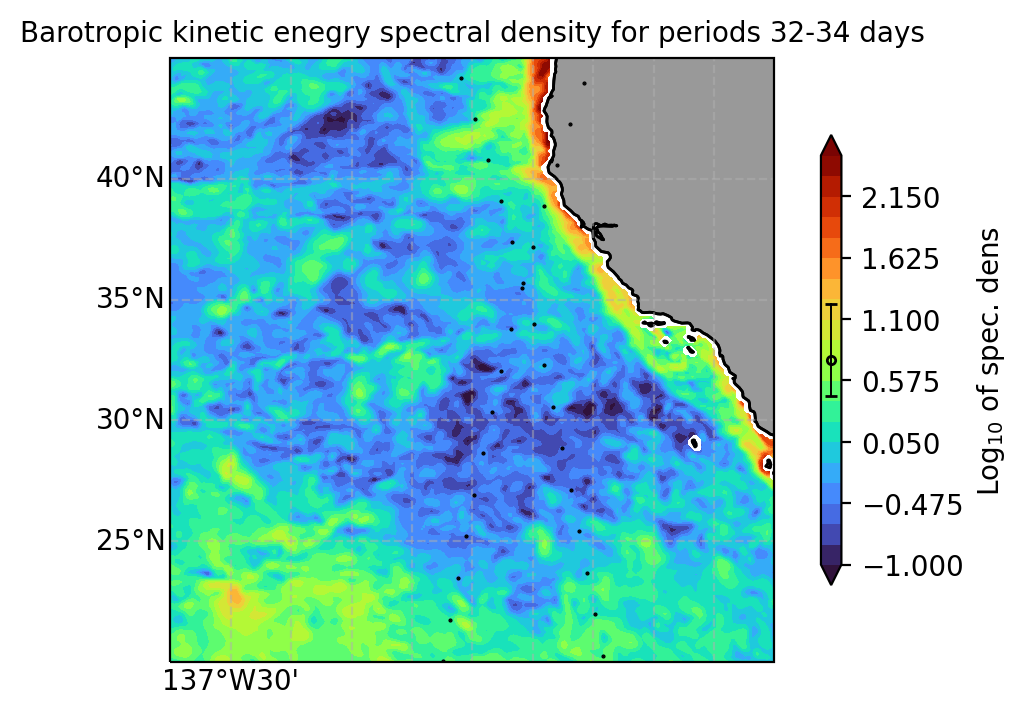

In [7]:
# %matplotlib qt 
###########################################
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Barotropic kinetic enegry spectral density for periods 32-34 days',size = 10.)

#plt.set_cmap(cmap=plt.get_cmap('nipy_spectral'))
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(-1,2.5,21)
cs = ax.contourf(lon,lat,np.log10(S_ke), levels, extend='both', transform=ccrs.PlateCarree())
# cb = plt.colorbar(cs,ax=ax,shrink=.8,pad=.05)
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Log$_{10}$ of spec. dens',fontsize = 10)

#draw error bar
low, up = np.log10([lower,upper])
cb_xlim = cb.ax.get_xlim() # xlim of colorbar in axis units
cb_ylim = cb.ax.get_ylim() # ylim of colorbar in axis units
xc = np.mean(cb_xlim) # center of colorbar
yc = np.mean(cb_ylim) # center of colorbar
cstr = 'k'
cb.ax.plot(xc,yc, marker = 'o',fillstyle='none', markersize= 3, color =cstr)
#upper bound of error bar at 1e1 spectral density
cb.ax.plot(xc, yc+up,marker = '_',fillstyle='none',markersize= 4,color =cstr )
cb.ax.plot([xc,xc], [yc+low,yc+up],linewidth= 0.7,color =cstr )
#lower bound of error bar at 1e1 spectral density
cb.ax.plot(xc,yc+low,marker = '_',fillstyle='none',markersize= 4,color =cstr )
# cb.ax.annotate('95%',(xc,yc),(cb_xlim[0]-5,yc+.1),annotation_clip=False,zorder=0)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='black',transform=ccrs.PlateCarree(),markersize = 4)
if plotswot:
    plt.plot(lon_calval,lat_calval,'.',color='black',markersize=1,transform=ccrs.PlateCarree());

if savefig:
    plt.savefig(__figdir__+'barotropic_KE_spectrum_raw.pdf',**savefig_args)


C:\Users\jtomf\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-12-4933f67370f4>:20: RuntimeWarning: divide by zero encountered in log10
  cs = ax.contourf(lon,lat,np.log10(S_h_2), levels, extend='both', transform=ccrs.PlateCarree())


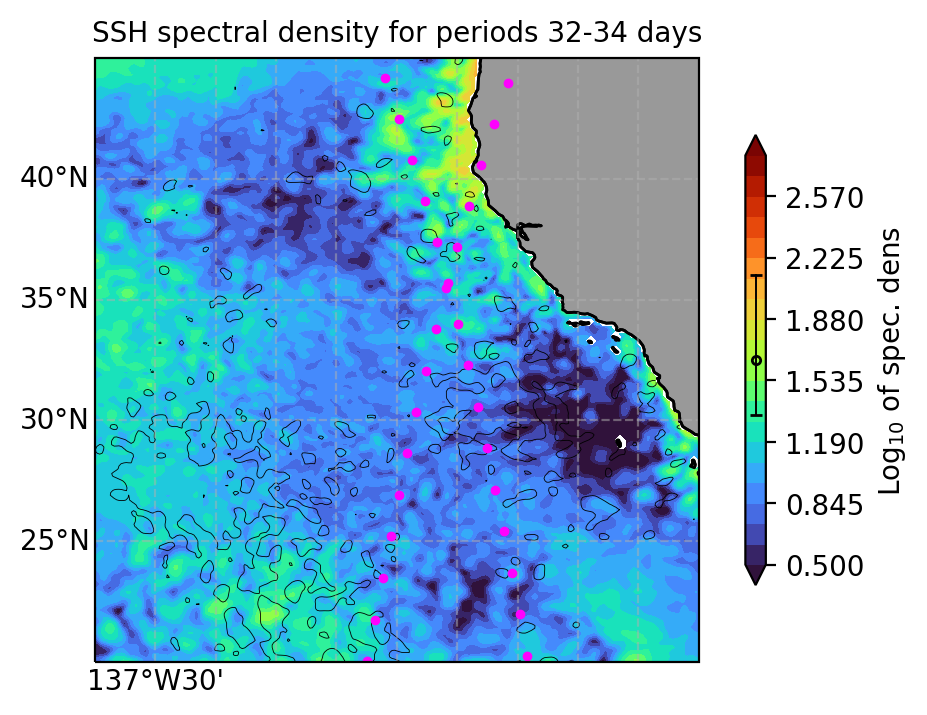

In [12]:
# %matplotlib qt 
###########################################
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('SSH spectral density for periods 32-34 days',size = 10.)

#plt.set_cmap(cmap=plt.get_cmap('nipy_spectral'))
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0.5,2.8,21)
cs = ax.contourf(lon,lat,np.log10(S_h_2), levels, extend='both', transform=ccrs.PlateCarree())
# cb = plt.colorbar(cs,ax=ax,shrink=.8,pad=.05)
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Log$_{10}$ of spec. dens',fontsize = 10)

if contour_coher:
    plt.contour(lon,lat,coh2,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())

#draw error bar
low, up = np.log10([lower,upper])
cb_xlim = cb.ax.get_xlim() # xlim of colorbar in axis units
cb_ylim = cb.ax.get_ylim() # ylim of colorbar in axis units
xc = np.mean(cb_xlim) # center of colorbar
yc = np.mean(cb_ylim) # center of colorbar
cstr = 'k'
cb.ax.plot(xc,yc, marker = 'o',fillstyle='none', markersize= 3, color =cstr)
#upper bound of error bar at 1e1 spectral density
cb.ax.plot(xc, yc+up,marker = '_',fillstyle='none',markersize= 4,color =cstr )
cb.ax.plot([xc,xc], [yc+low,yc+up],linewidth= 0.7,color =cstr )
#lower bound of error bar at 1e1 spectral density
cb.ax.plot(xc,yc+low,marker = '_',fillstyle='none',markersize= 4,color =cstr )
# cb.ax.annotate('95%',(xc,yc),(cb_xlim[0]-5,yc+.1),annotation_clip=False,zorder=0)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='black',transform=ccrs.PlateCarree(),markersize = 4);
if plotswot:
    plt.plot(lon_calval,lat_calval,'.',color='magenta',markersize=5,transform=ccrs.PlateCarree());

if savefig:
    if contour_coher:
        if zoom:
            plt.savefig(__figdir__+'SSH_spectrum_raw_w_coher_zoom.pdf',**savefig_args)
        else:
            plt.savefig(__figdir__+'SSH_spectrum_raw_w_coher.pdf',**savefig_args)
    else:
        if zoom:
            plt.savefig(__figdir__+'SSH_spectrum_raw_zoom.pdf',**savefig_args)
        else:
            plt.savefig(__figdir__+'SSH_spectrum_raw.pdf',**savefig_args)


In [9]:
# If doing interactive zoom:
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')

C:\Users\jtomf\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-10-42906d712cb4>:20: RuntimeWarning: divide by zero encountered in log10
  cs = ax.contourf(lon,lat,np.log10(S_h), levels, extend='both', transform=ccrs.PlateCarree())


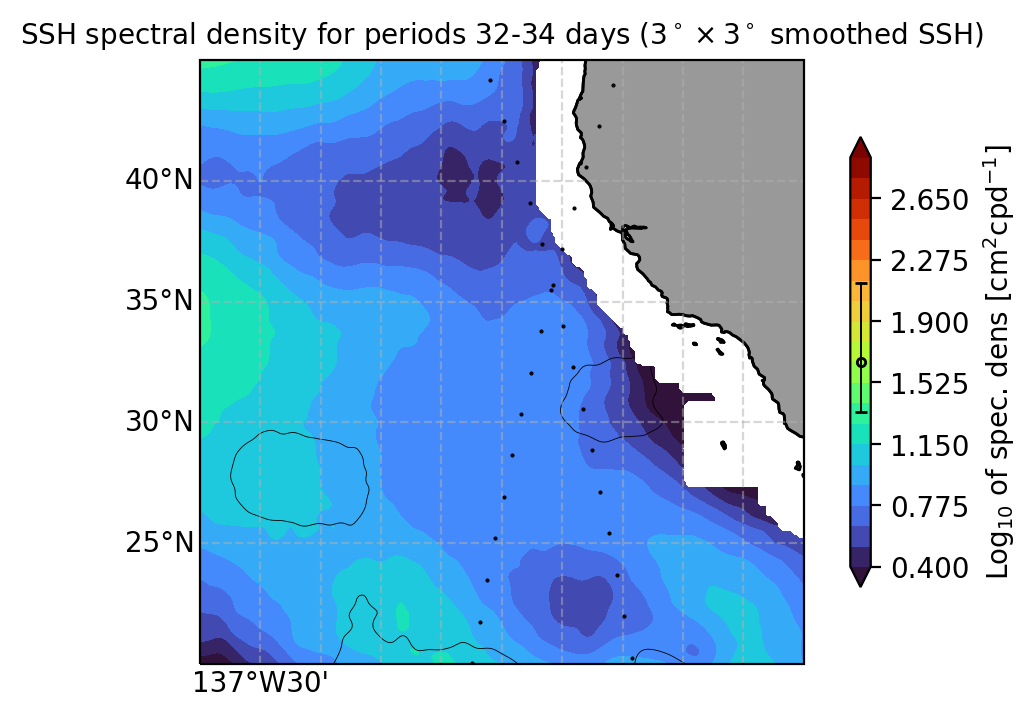

In [10]:
# %matplotlib qt 
###########################################
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title(r'SSH spectral density for periods 32-34 days (3$^\circ\times$3$^\circ$ smoothed SSH)',size = 10.)

#plt.set_cmap(cmap=plt.get_cmap('nipy_spectral'))
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0.4,2.9,21)
cs = ax.contourf(lon,lat,np.log10(S_h), levels, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Log$_{10}$ of spec. dens [cm$^2$cpd$^{-1}$]',fontsize = 10)

if contour_coher:
    plt.contour(lon,lat,coh1,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())

#draw error bar
low, up = np.log10([lower,upper])
cb_xlim = cb.ax.get_xlim() # width of colorbar in axis units
cb_ylim = cb.ax.get_ylim() # width of colorbar in axis units
xc = np.mean(cb_xlim) # center of colorbar
yc = np.mean(cb_ylim) # center of colorbar
cstr = 'k'
cb.ax.plot(xc,yc, marker = 'o',fillstyle='none', markersize= 3, color =cstr)
#upper bound of error bar at 1e1 spectral density
cb.ax.plot(xc, yc+up,marker = '_',fillstyle='none',markersize= 4,color =cstr )
cb.ax.plot([xc,xc], [yc+low,yc+up],linewidth= 0.7,color =cstr )
#lower bound of error bar at 1e1 spectral density
cb.ax.plot(xc,yc+low,marker = '_',fillstyle='none',markersize= 4,color =cstr )
# cb.ax.annotate('95%',(xc,yc),(cb_xlim[0]-5,yc+.1),annotation_clip=False,zorder=0)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='black',transform=ccrs.PlateCarree(),markersize = 4)
if plotswot:
    plt.plot(lon_calval,lat_calval,'.',color='black',markersize=1,transform=ccrs.PlateCarree());

# plt.show()

if savefig:
    if contour_coher:
        if zoom:
            plt.savefig(__figdir__+'SSH_spectrum_smooth_w_coher_zoom.pdf',**savefig_args)
        else:
            plt.savefig(__figdir__+'SSH_spectrum_smooth_w_coher.pdf',**savefig_args)
    else:
        if zoom:
            plt.savefig(__figdir__+'SSH_spectrum_smooth_zoom.pdf',**savefig_args)
        else:
            plt.savefig(__figdir__+'SSH_spectrum_smooth.pdf',**savefig_args)
